In [21]:
# 
# Потестируем разные модели для аппроксимации даты, точки в которой
# распределены в виде сигмоиды. Попробуем линейную регрессию, полиномиальную регрессию
# метод К-ближайших соседей, метод опорных векторов, дерево решений, случайный лес, 
# градиентный бустинг и адабустинг.
#

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Дата представляет собой результаты лабораторных тестов - в них измеряется отражённый сигнал, 
# полученный сенсорами на разных частотах в герцах, для различной плотности камня. 
# Оказалось, что если отобразить эти результаты на графике, то мы получим синусоиду - 
# с изменением плотности камня уровень отражённого сигнала меняется волнообразно.

df = pd.read_csv(r"C:\Users\chist\Desktop\ML\UNZIP_ME_FOR_NOTEBOOKS_ML_RUS_V1\DATA\rock_density_xray.csv")
df.head()

,Rebound Signal Strength nHz,Rock Density kg/m3
0,72.945124,2.456548
1,14.229877,2.601719
2,36.597334,1.967004
3,9.578899,2.300439
4,21.765897,2.452374


<AxesSubplot:xlabel='Rebound Signal Strength nHz', ylabel='Rock Density kg/m3'>

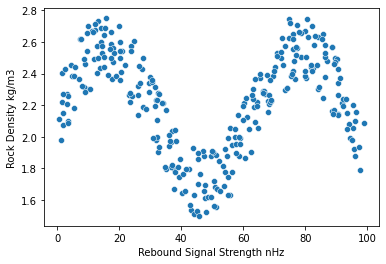

In [3]:
sns.scatterplot(data=df, x='Rebound Signal Strength nHz', y='Rock Density kg/m3')

In [4]:
df.columns = ['Signal', 'Density']
df.head()

,Signal,Density
0,72.945124,2.456548
1,14.229877,2.601719
2,36.597334,1.967004
3,9.578899,2.300439
4,21.765897,2.452374


In [5]:
# т.к. в датасете 1 фича, кроме целевой переменной, ее необходимо решейпнуть из объекта pd.Series в pd.DataFrame
X = df['Signal'].values.reshape(-1,1)
y = df['Density']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# строим простейшую модель линейной регрессии

from sklearn.linear_model import LinearRegression

lin_model = LinearRegression().fit(X_train, y_train)

In [6]:
lin_pred = lin_model.predict(X_test)

In [7]:
# импортируем метрики качества модели

from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE = mean_absolute_error(lin_pred, y_test)
RMSE = np.sqrt(mean_squared_error(lin_pred, y_test))
print(f" Mean= {y.mean()} \n MAE=  {MAE} \n RMSE= {RMSE}")

 Mean= 2.225062949323796 
 MAE=  0.2369211828242143 
 RMSE= 0.2928014017261052


In [8]:
# Напишем функцию для уменьшения количества кода. Функция посчитает метрики качества и построит график аппроксимации

def run_model(model, X_train, y_train, X_test, y_test):
    
    #Обучение модели
    model.fit(X_train, y_train)
    
    #Вычисляем метрики
    preds = model.predict(X_test)
    MAE = mean_absolute_error(preds, y_test)
    RMSE = np.sqrt(mean_squared_error(preds, y_test))
    print(f"MAE=  {MAE} \n RMSE= {RMSE}")
    
    # строим график с результатами
    signal_range = np.arange(0,100)
    signal_preds = model.predict(signal_range.reshape(-1,1))
    
    plt.figure(figsize=(10,6), dpi=200)
    sns.scatterplot(data=df, x='Signal', y='Density', color='black')
    plt.plot(signal_range, signal_preds)

MAE=  0.2369211828242143 
 RMSE= 0.2928014017261052


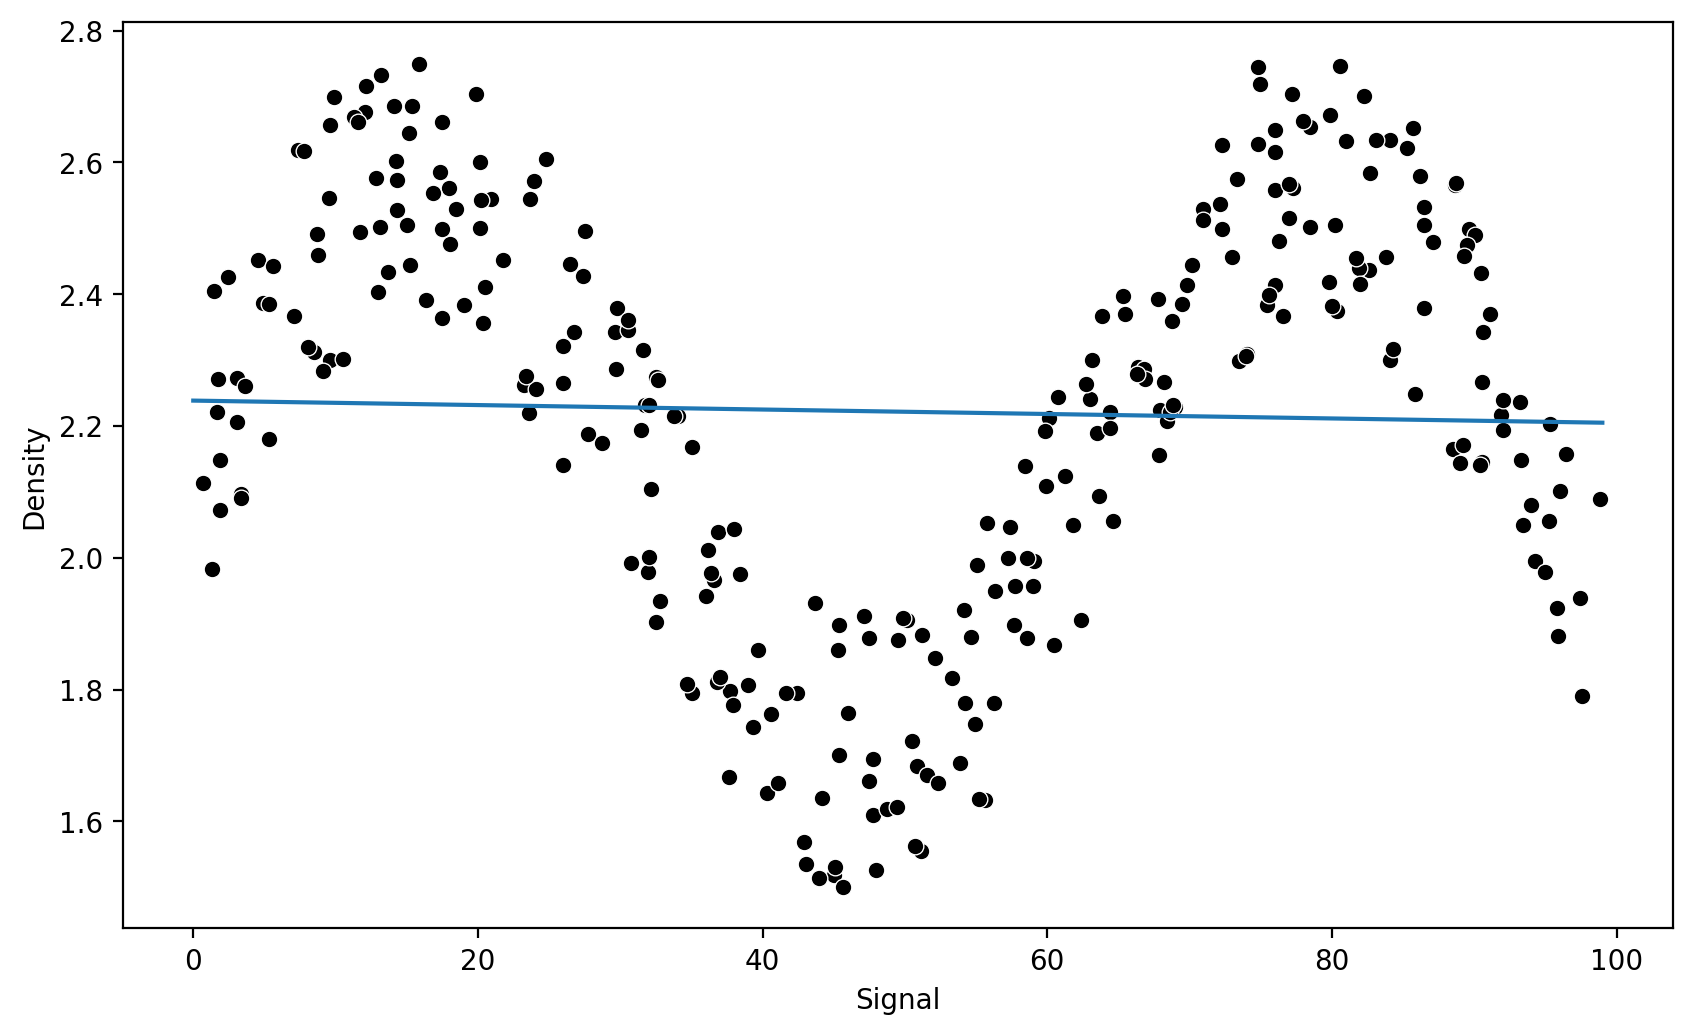

In [9]:
model = LinearRegression()
run_model(model, X_train, y_train, X_test, y_test)

MAE=  0.11503333720555477 
 RMSE= 0.1332812438788268


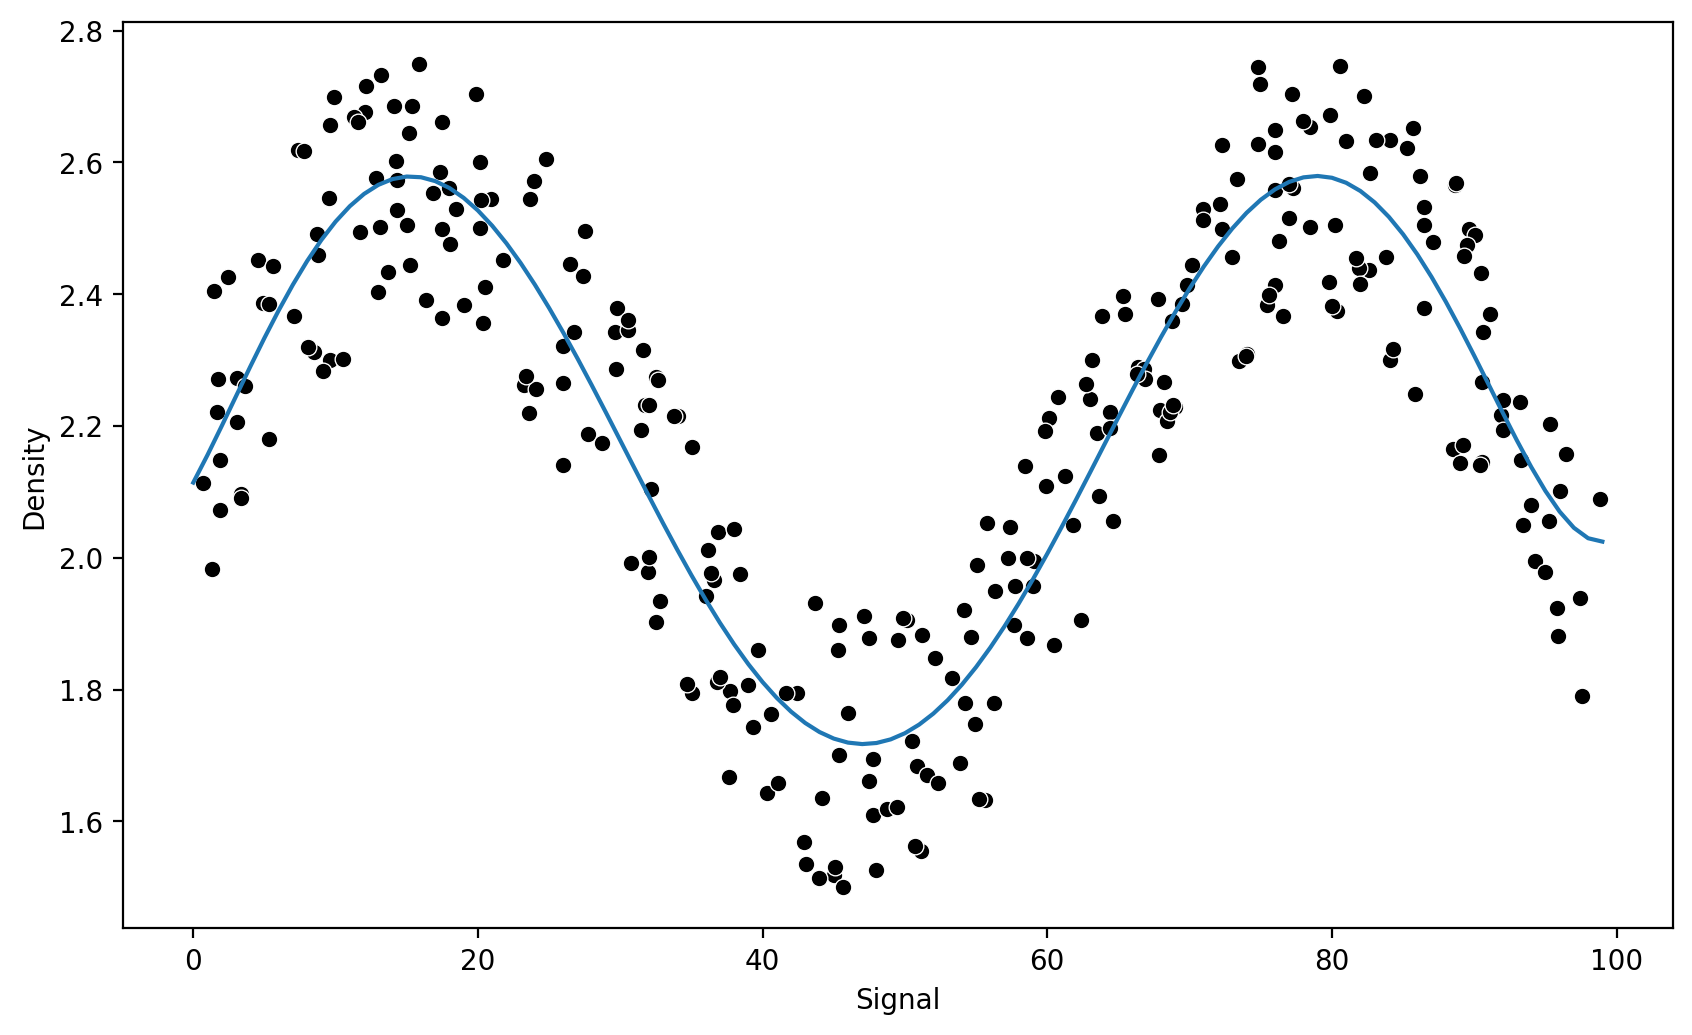

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# создаем упрощенный объект pipe который работает как модель
pipe = make_pipeline(PolynomialFeatures(degree=6), LinearRegression())

run_model(pipe, X_train, y_train, X_test, y_test)

MAE=  0.11511554216487732 
 RMSE= 0.13875028455158084


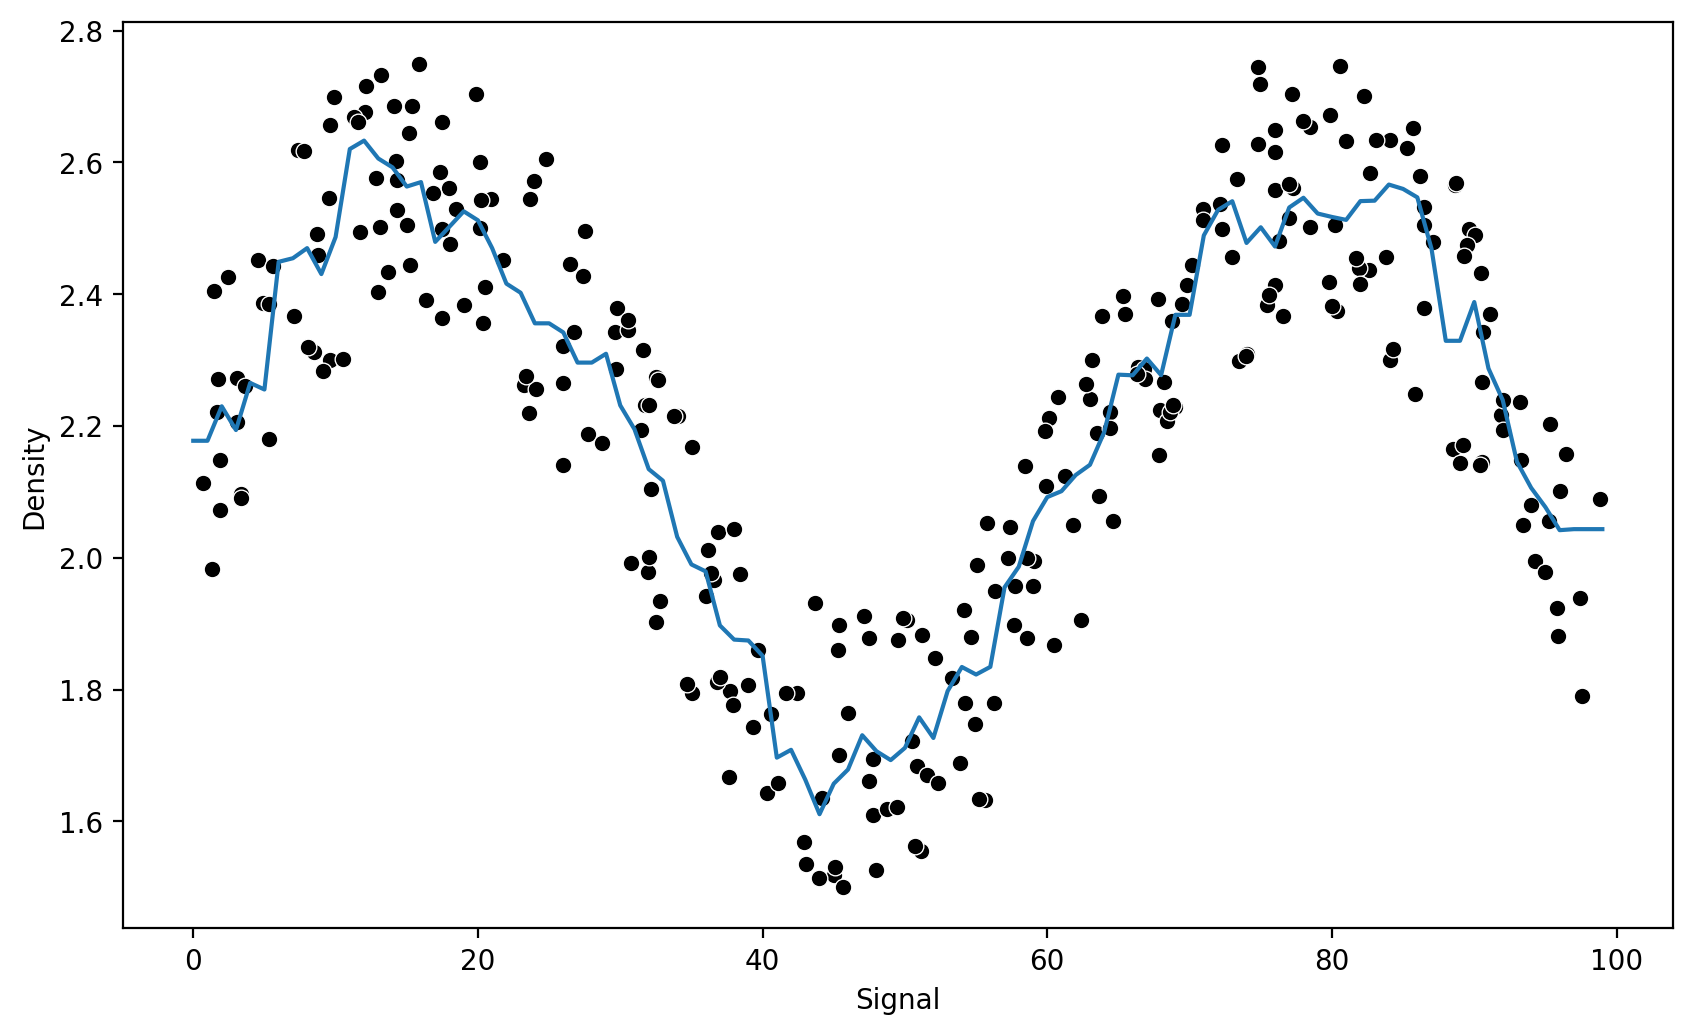

In [11]:
# можно подобрать нужное количество K подбором или через цикл.
# С помощью подбора графическим методом выбираем оптимальное количество ближайших соседей = 6
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=6)

run_model(model, X_train, y_train, X_test, y_test)

MAE=  0.12817936228823248 
 RMSE= 0.16153547162673088


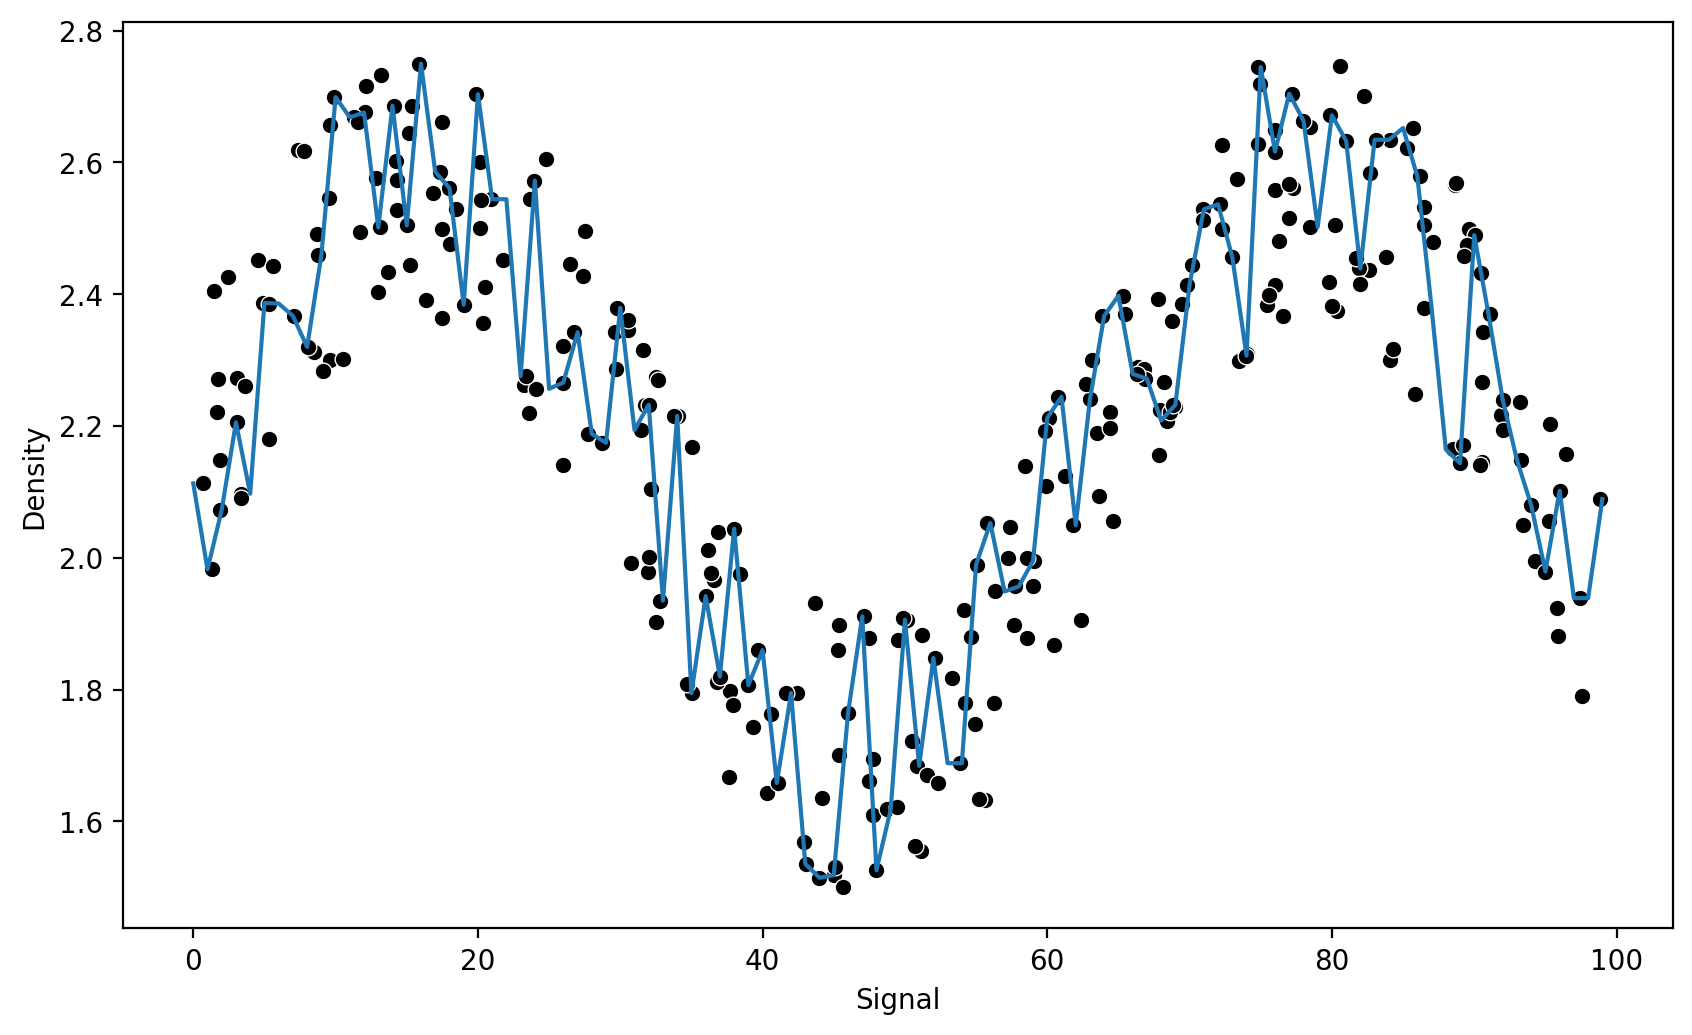

In [12]:
# одно дерево решений (не ансамбль) слишком отвлекается на шумы и выдает переобученную модель

from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()

run_model(model, X_train, y_train, X_test, y_test)

In [13]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

MAE=  0.11109268029065332 
 RMSE= 0.1297939230748568


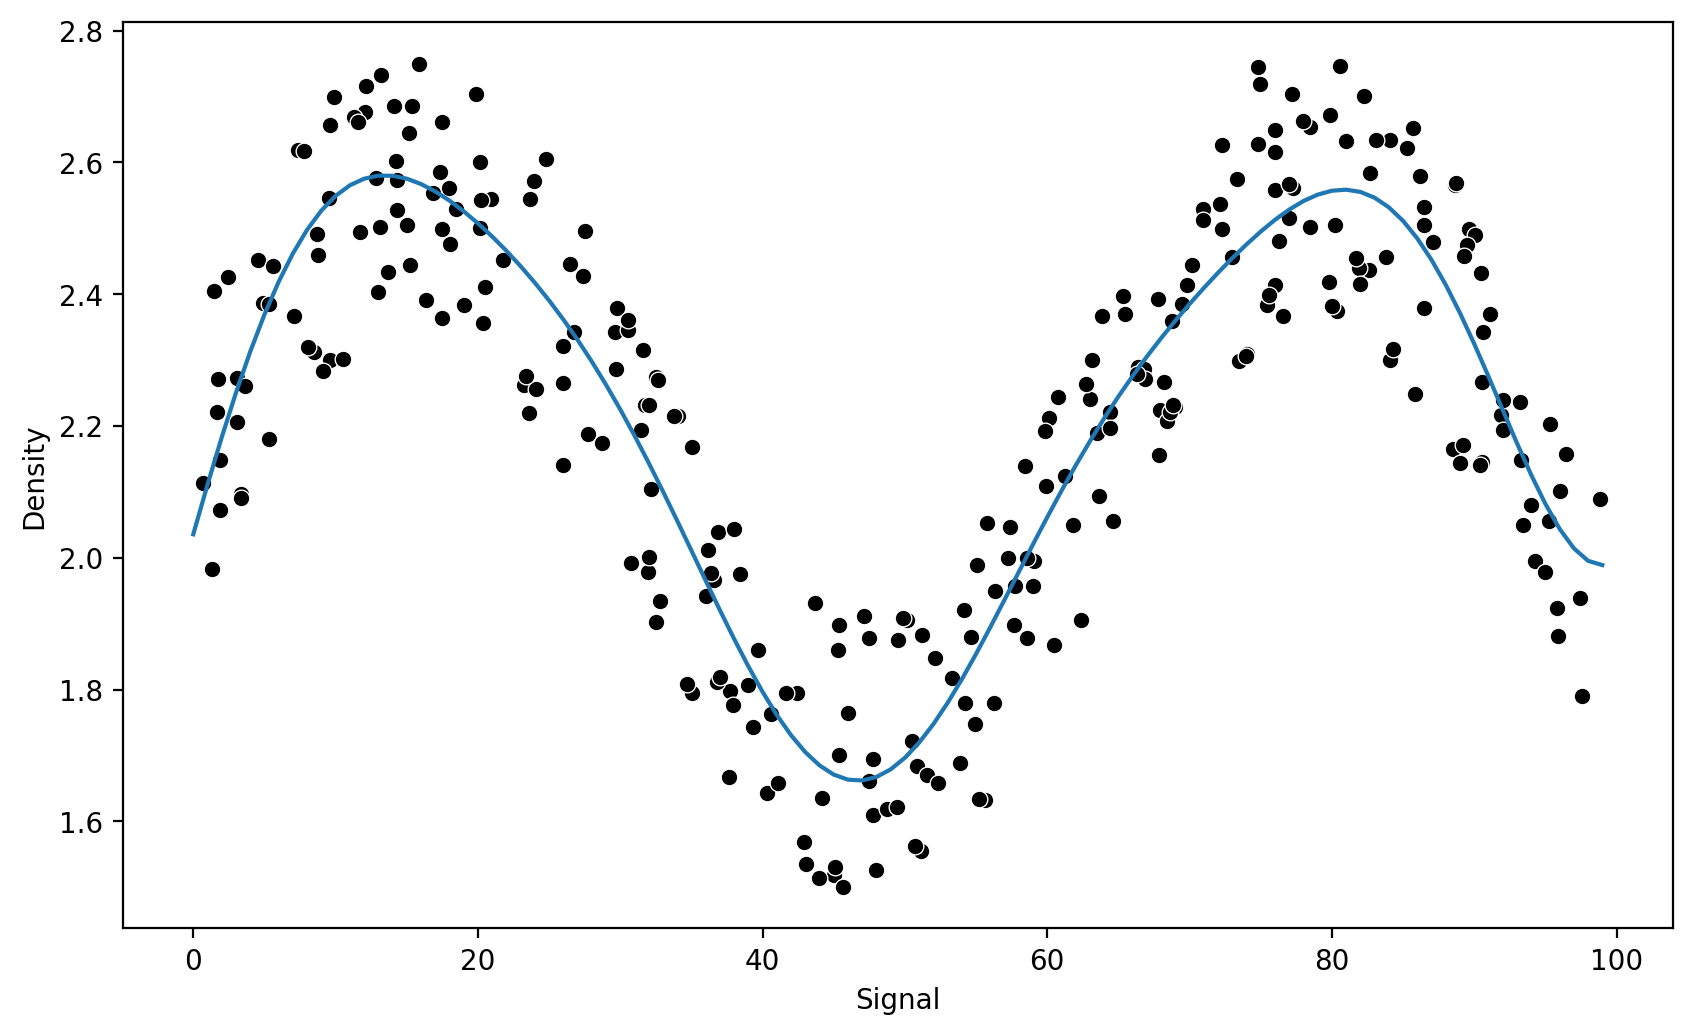

In [14]:
svr = SVR()
param_grid = {'C':[0.01, 0.1, 0.5, 1, 5, 10, 100, 1000, 1200, 1400, 1500, 1600], 
              'gamma': ['scale', 'auto']}

grid = GridSearchCV(svr, param_grid)

run_model(grid, X_train, y_train, X_test, y_test)

# самым лучшим образом показала себя модель SVR

In [15]:
grid.best_params_

{'C': 1200, 'gamma': 'scale'}

MAE=  0.11826914903657829 
 RMSE= 0.14428721242627976


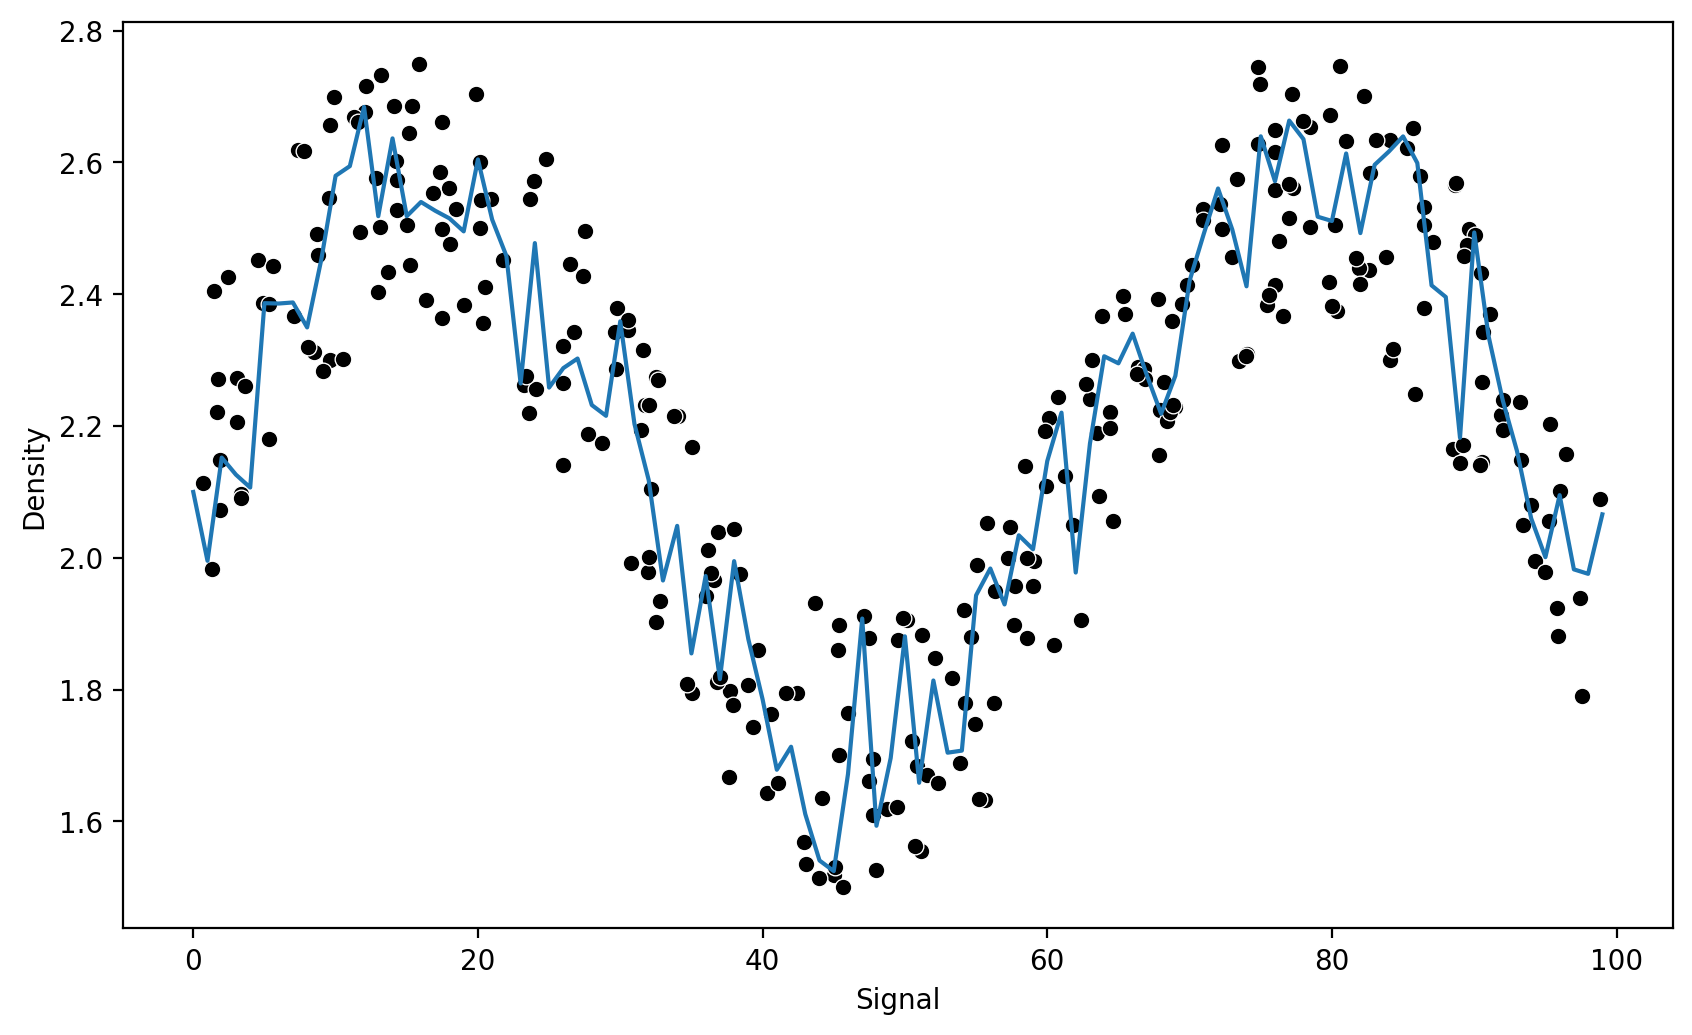

In [16]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=10)

run_model(rfr, X_train, y_train, X_test, y_test)

MAE=  0.11184318220220522 
 RMSE= 0.13336766447799286


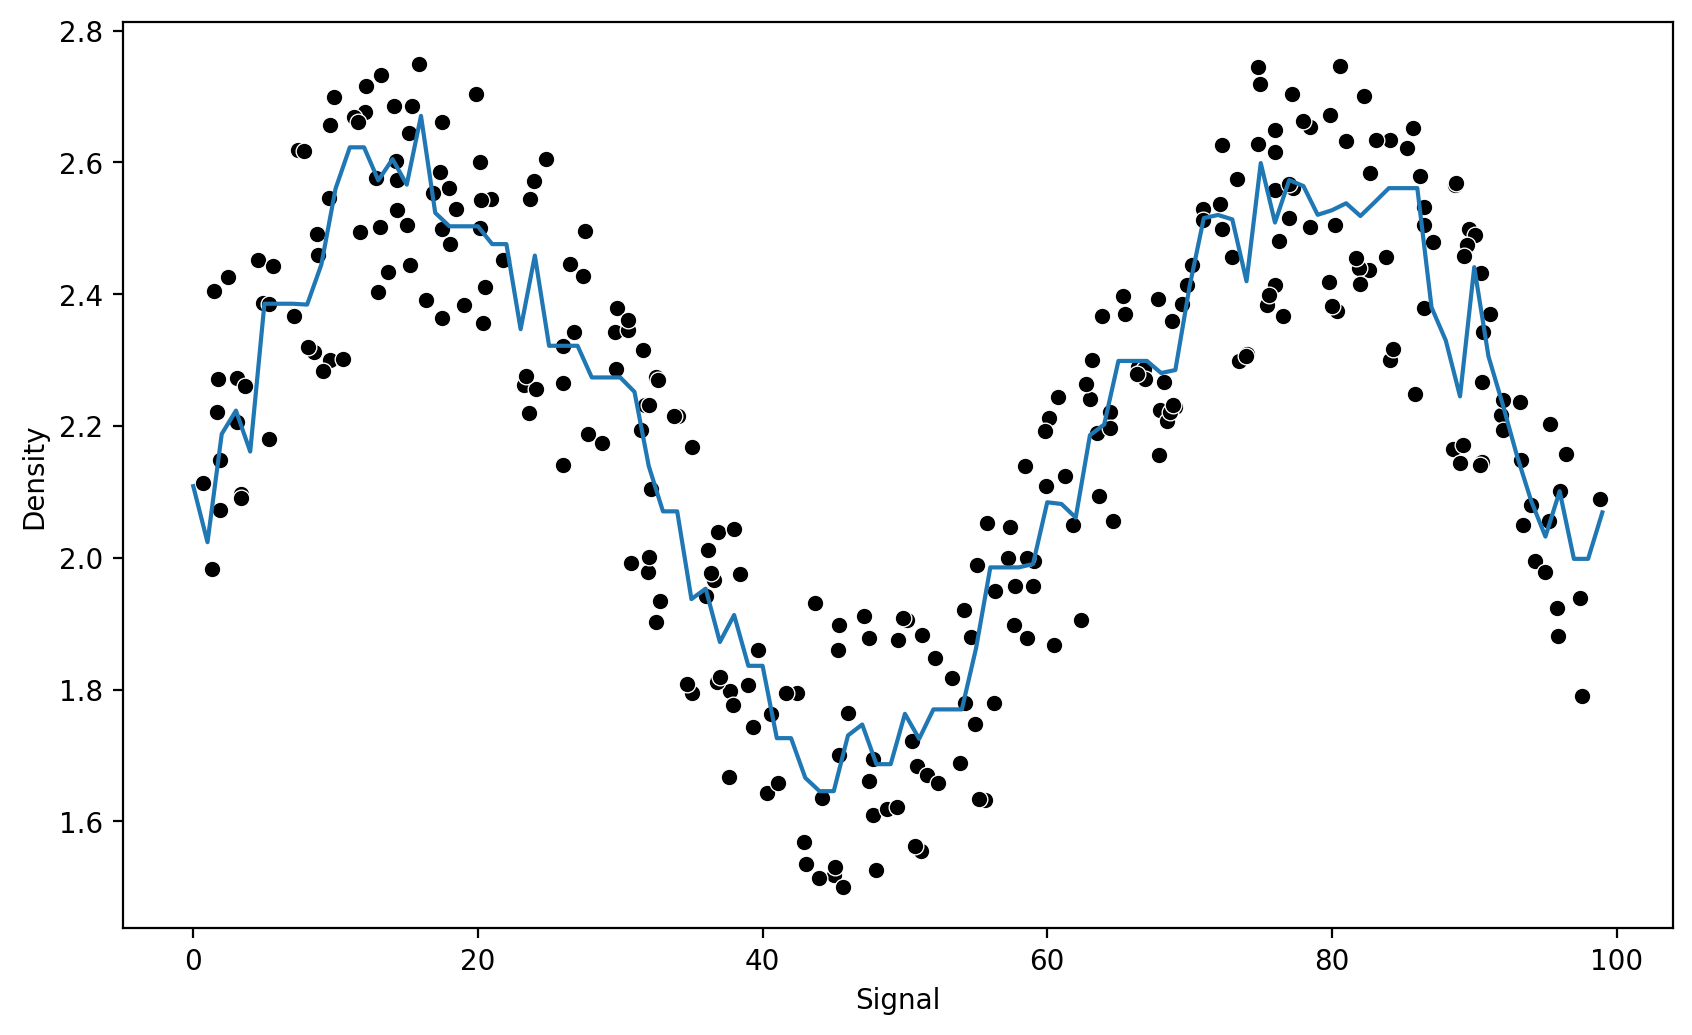

In [17]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

model_grad = GradientBoostingRegressor()

run_model(model_grad, X_train, y_train, X_test, y_test)

MAE=  0.11330888750925258 
 RMSE= 0.1339907400168001


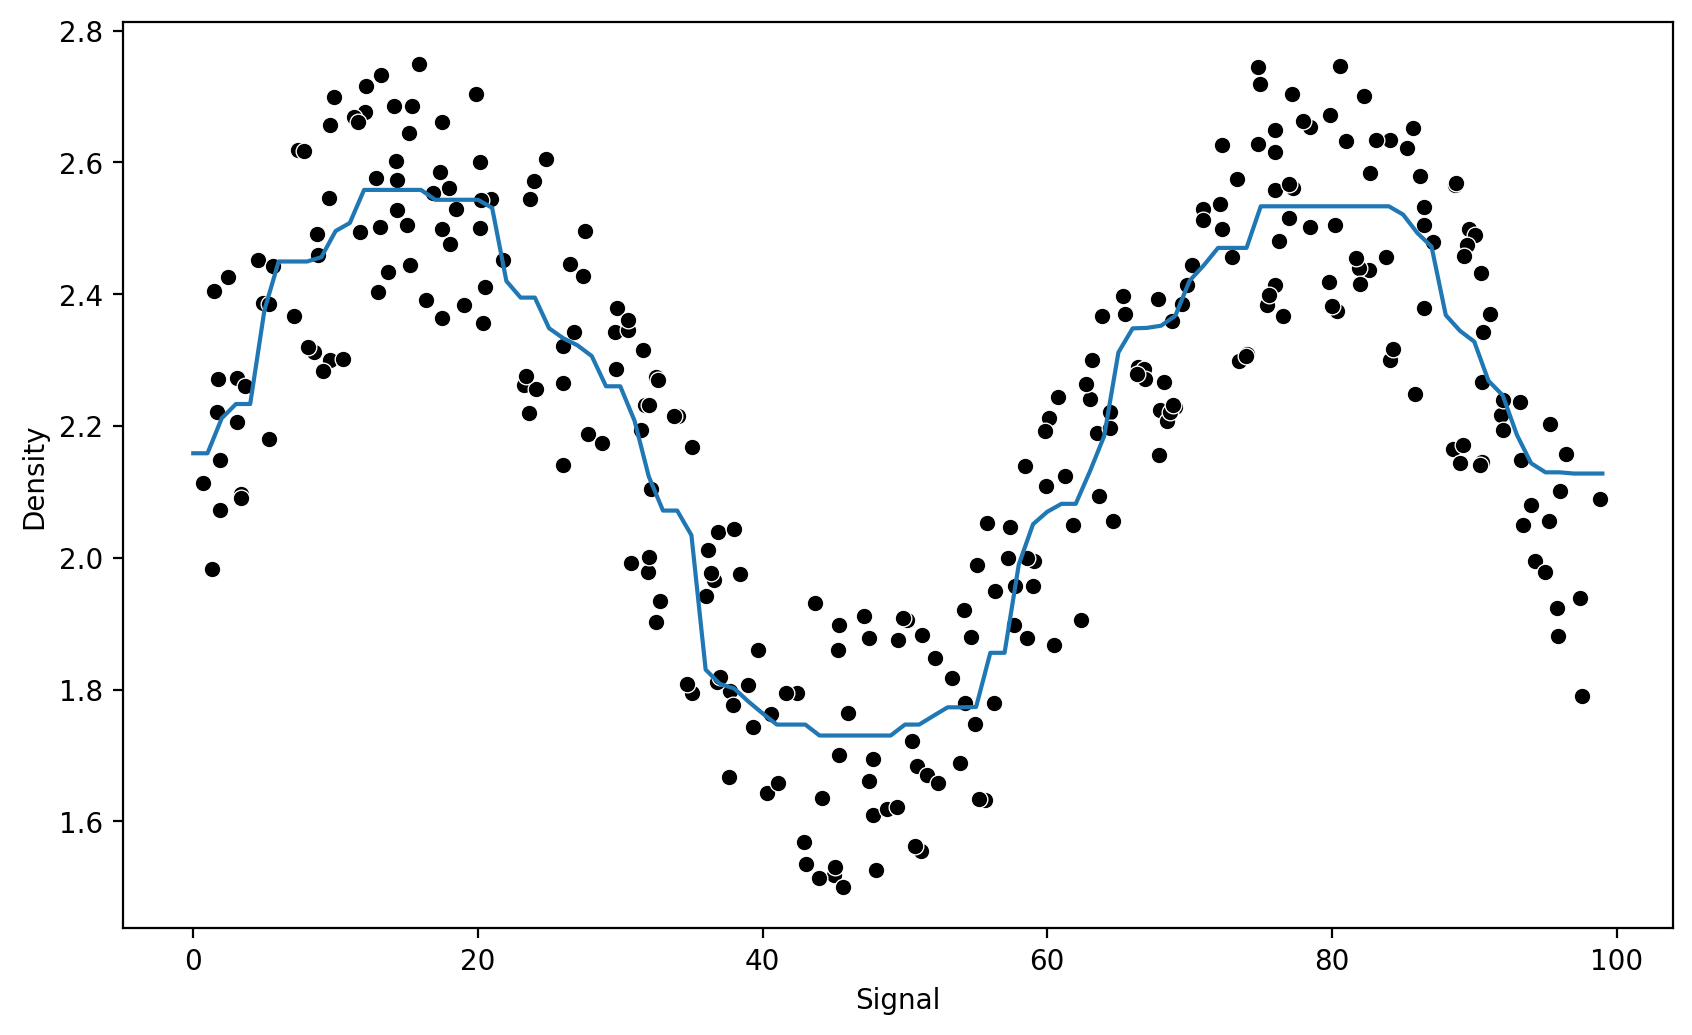

In [18]:
model_ada = AdaBoostRegressor()

run_model(model_ada, X_train, y_train, X_test, y_test)